In [1]:
#!pip3 install -U -r requirements.txt

In [11]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

from tqdm.notebook import trange, tqdm

# import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import plotly
plotly.offline.init_notebook_mode(connected=True)
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK']="1"

In [12]:
device = torch.device("mps")

## Load Data

In [13]:
from avalanche.benchmarks import SplitCIFAR10

benchmark = SplitCIFAR10(
    n_experiences=1,
    return_task_id=True,
    shuffle=False,
    dataset_root='../datasets',
    train_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    ]),
    eval_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    ]),
)

training_data = benchmark.train_stream[0].dataset
validation_data = benchmark.test_stream[0].dataset

Files already downloaded and verified
Files already downloaded and verified


In [14]:
data_variance = 0.06328692405746414

In [15]:
# data_variance = np.var(training_data.data / 255.0)

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [16]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1 / self._num_embeddings, 1 / self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [17]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, embedding, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BHW -> BHWC
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.reshape(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                    (self._ema_cluster_size + self._epsilon)
                    / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized, perplexity, encoding_indices

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [18]:
# Copyright (c) Facebook, Inc. and its affiliates.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Mostly copy-paste from timm library.
https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
"""
import math
from functools import partial

import torch
import torch.nn as nn

from torch.nn.init import trunc_normal_

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        if return_attention:
            return x, attn
        else:
            return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, num_classes=0, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)

    def forward(self, x, return_all_patches=False):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        if return_all_patches:
            return x
        else:
            return x[:, 0]

    def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                x, attn = blk(x, return_attention=True)
                x = self.norm(x)
                return x, attn

    def get_intermediate_layers(self, x, n=1):
        x = self.prepare_tokens(x)
        # we return the output tokens from the `n` last blocks
        output = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if len(self.blocks) - i <= n:
                output.append(self.norm(x))
        return output


def vit_tiny(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_small(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_base(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, use_bn=False, norm_last_layer=True, nlayers=3, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        nlayers = max(nlayers, 1)
        if nlayers == 1:
            self.mlp = nn.Linear(in_dim, bottleneck_dim)
        else:
            layers = [nn.Linear(in_dim, hidden_dim)]
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
            for _ in range(nlayers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                if use_bn:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.mlp(x)
        x = nn.functional.normalize(x, dim=-1, p=2)
        x = self.last_layer(x)
        return x


class VisionTransformerWithLinear(nn.Module):

    def __init__(self, base_vit, num_classes=200):

        super().__init__()

        self.base_vit = base_vit
        self.fc = nn.LazyLinear(num_classes)

    def forward(self, x, return_features=False):

        features = self.base_vit.forward(x, return_all_patches=True)
        features = torch.nn.functional.normalize(features, dim=-1)
        logits = self.fc(features[:, 0])

        if return_features:
            return logits, features
        else:
            return logits

    @torch.no_grad()
    def normalize_prototypes(self):
        w = self.fc.weight.data.clone()
        w = torch.nn.functional.normalize(w, dim=1, p=2)
        self.fc.weight.copy_(w)

In [19]:
class Encoder(nn.Module):
    def __init__(self, image_embedding_dim, vit_embeddings_dim, vit_patch_size):
        super(Encoder, self).__init__()

        base_vit = VisionTransformer(
            img_size=[32],
            patch_size=patch_size,
            num_layers=12,
            embed_dim=embeddings_dim,
            depth=12,
            num_heads=8,
            mlp_ratio=4,
            qkv_bias=True,
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
        )
        self.vit = VisionTransformerWithLinear(base_vit, image_embedding_dim)

    def forward(self, inputs):
        return self.vit(inputs, return_features=True)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (2076326347.py, line 5)

In [66]:
base_vit = VisionTransformer(
    img_size=[8],
    in_chans=64,
    patch_size=1, 
    embed_dim=64, 
    depth=12, 
    num_heads=8, 
    mlp_ratio=4,
    qkv_bias=True, 
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
)

base_vit(torch.rand(2, 64, 8, 8), return_all_patches=True).shape

torch.Size([2, 65, 64])

In [68]:
from transformers import ImageGPTConfig, ImageGPTForCausalImageModeling, AutoImageProcessor, ImageGPTModel
    
class Decoder(nn.Module):
    def __init__(self, embeddings_dim, embeddings_num, n_positions):
        super(Decoder, self).__init__()
        
        self.base_vit = VisionTransformer(
            img_size=[8],
            patch_size=1,
            num_layers=12,
            embed_dim=embeddings_dim,
            depth=12,
            num_heads=8,
            mlp_ratio=4,
            qkv_bias=True,
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
        )
        self.linear = nn.Linear(embeddings_dim, 16*3) 

        
    def forward(self, inputs):
        x = self.base_vit(inputs_embeds=inputs, return_all_patches=True)
        x = self.linear(x[:, 1:])
        x = x.reshape(-1, 3, 32, 32)
        return x

In [69]:
from pytorch_metric_learning.losses import ContrastiveLoss
from pytorch_metric_learning.reducers import MultipleReducers, ThresholdReducer, MeanReducer, SumReducer
from pytorch_metric_learning.distances import CosineSimilarity, LpDistance, BaseDistance
from torch.nn import functional as F
from copy import deepcopy
        
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(64, embedding_dim, vit_patch_size=4)
        
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        
        self._decoder = Decoder(embedding_dim, num_embeddings, n_positions=8*8 + 1)
        
    def forward(self, x, y):
        image_emb, z = self._encoder(x)
        patches_emb = z[:, 1:]
        
        vq_loss, quantized, perplexity, _ = self._vq_vae(patches_emb)
        x_recon = self._decoder(quantized)
        
        return vq_loss, image_emb, x_recon, perplexity

## Train

We use the hyperparameters from the author's code:

In [70]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [71]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

In [72]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [73]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).cpu()

/Users/ewriji/Desktop/work/RND/.venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



In [74]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [75]:
import torch.nn.functional as F
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
from plotly.subplots import make_subplots
from torch.utils.tensorboard import SummaryWriter

%set_env PYTORCH_ENABLE_MPS_FALLBACK=1

device = torch.device('mps')
model.to(device)

writer = SummaryWriter(log_dir='/Users/ewriji/Desktop/work/RND/logs/transformer_vqvae/version_1')
c_loss = ContrastiveLoss(pos_margin = 1, neg_margin = 0, distance=CosineSimilarity())
best_val = float('+inf')

for i in range(248, 1000):
    model.train()

    epoch_losses = []
    epoch_recon_error = []
    epoch_perplexity = []
    epoch_constrative_losses = []
    
    
    for (batch, y, *_) in tqdm(training_loader):
        optimizer.zero_grad()
        
        batch = batch.to(device)
        y = y.to(device)
                
        vq_loss, image_emb, x_recon, perplexity = model(batch, y)

        recon_error = F.mse_loss(x_recon, batch) / data_variance
        constrative_loss = c_loss(image_emb, y)

        loss = recon_error + vq_loss + constrative_loss
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.cpu().item())
        epoch_recon_error.append(recon_error.cpu().item())
        epoch_perplexity.append(perplexity.cpu().item())
        epoch_constrative_losses.append(constrative_loss.cpu().item())
        
    writer.add_scalar('train/loss', np.mean(epoch_losses), i)
    writer.add_scalar('train/recon_error', np.mean(epoch_recon_error), i)
    writer.add_scalar('train/perplexity', np.mean(epoch_perplexity), i)
    writer.add_scalar('train/constrative_loss', np.mean(epoch_constrative_losses), i)
    
    if i % 2 ==0:
        model.eval()
        epoch_losses = []
        epoch_recon_error = []
        epoch_perplexity = []
        epoch_constrative_losses = []

        with torch.no_grad():
            for (batch, y, *_) in tqdm(validation_loader):
                
                batch = batch.to(device)
                y = y.to(device)
                
                vq_loss, image_emb, x_recon, perplexity = model(batch, y)

                recon_error = F.mse_loss(x_recon, batch) / data_variance
                constrative_loss = c_loss(image_emb, y)

                loss = recon_error + vq_loss + constrative_loss
                
                epoch_losses.append(loss.cpu().item())
                epoch_recon_error.append(recon_error.cpu().item())
                epoch_perplexity.append(perplexity.cpu().item())
                epoch_constrative_losses.append(constrative_loss.cpu().item())

        writer.add_scalar('test/loss', np.mean(epoch_losses), i)
        writer.add_scalar('test/recon_error', np.mean(epoch_recon_error), i)
        writer.add_scalar('test/perplexity', np.mean(epoch_perplexity), i)
        writer.add_scalar('test/constrative_loss', np.mean(epoch_constrative_losses), i)
        
        
        if np.mean(epoch_losses) < best_val:
            torch.save(model.cpu().state_dict(), 'transformer_vq_vae.ph')
            model.to(device)
            
            best_val = np.mean(epoch_losses)
        
        

env: PYTORCH_ENABLE_MPS_FALLBACK=1


  0%|          | 0/196 [00:00<?, ?it/s]

TypeError: VisionTransformerWithLinear.forward() got an unexpected keyword argument 'return_all_patches'

## Plot Loss

In [154]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

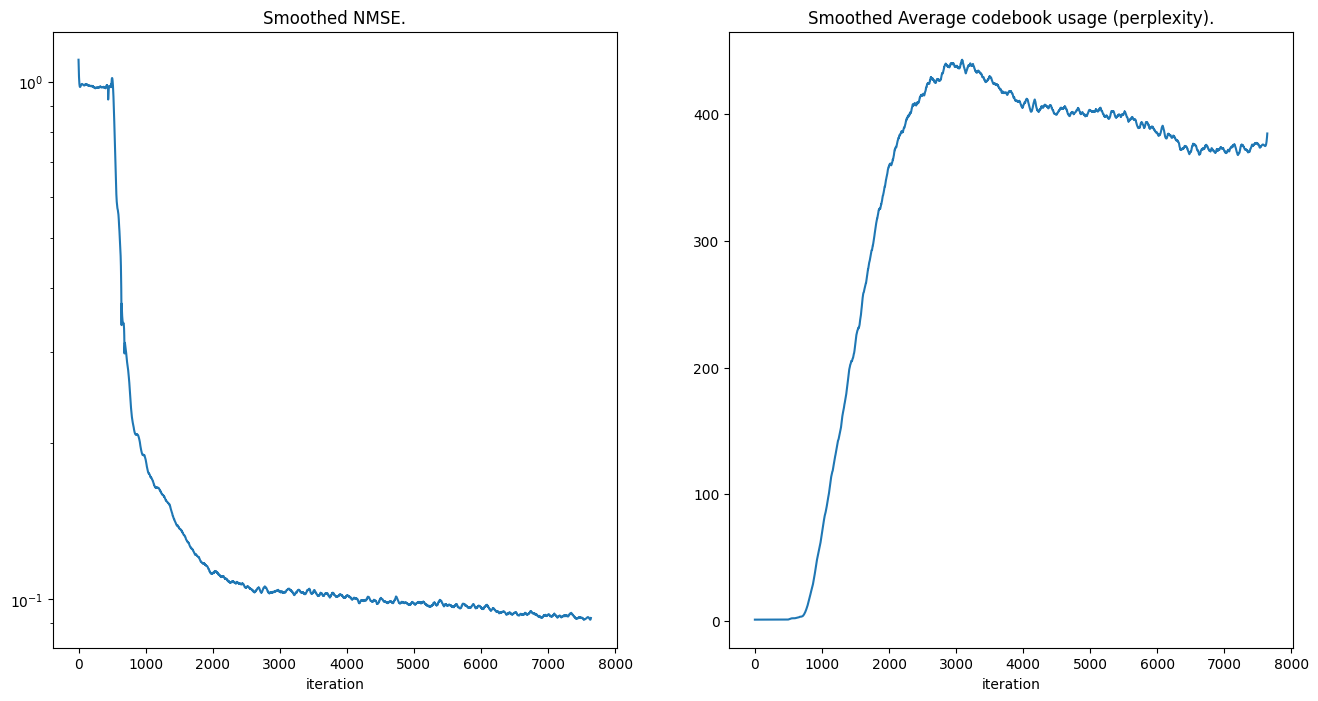

In [155]:
f = plt.figure(figsize=(16, 8))
ax = f.add_subplot(1, 2, 1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1, 2, 2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [82]:
# torch.save(model.state_dict(), 'vq_vae_cifar10.ph')

## View Reconstructions

In [48]:
model.eval()
model.to(device)

with torch.no_grad():
    (valid_originals, y, *_) = next(iter(validation_loader))
    valid_originals = valid_originals.to(device)

    valid_originals = valid_originals.to(device)
    y = y.to(device)

    _, _, valid_reconstructions, _ = model(valid_originals, y)

In [49]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


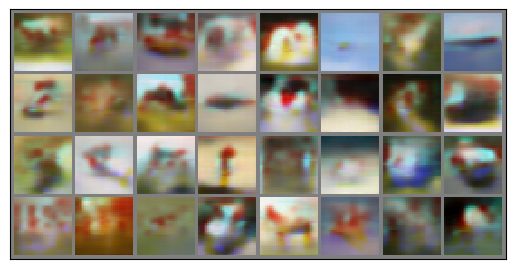

In [50]:
show(make_grid(valid_reconstructions.cpu().data) + 0.5, )

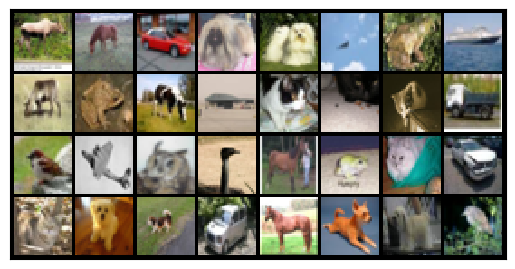

In [51]:
show(make_grid(valid_originals.cpu() + 0.5))

# View Embedding

In [40]:
import umap

proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())
plt.scatter(proj[:, 0], proj[:, 1], alpha=0.3)

ModuleNotFoundError: No module named 'umap'

# Save/Reload model

In [161]:
torch.save(model.cpu().state_dict(), 'transformer_vq_vae.ph')
# model.load_state_dict(torch.load('vq_vae_cl1_zol_contr.ph'))
# model.to(device)
""

''

## Train ImageGPT

In [27]:
# %load_ext autoreload
# %autoreload 2

In [39]:
from torch.utils.data import Dataset
from tqdm.notebook import tqdm


# Create dataset

class ImageGPTDataset(Dataset):

    def __init__(self, vq_vae_model, dataset, sos_token, with_latents=False):
        super().__init__()

        self.sos_token = sos_token
        self.with_latents = with_latents
        self.values = []
        self.targets = []
        self.embeddigns = []

        self.vq_vae_model = vq_vae_model
        self.dataset = dataset

        self._project_dataset(vq_vae_model, dataset)

    def __getitem__(self, item):
        if not self.with_latents:
            return {'input_ids': self.values[item], "labels": self.targets[item]}
        else:
            return {
                "input_ids": self.values[item], 
                "labels": self.targets[item],
                "latents": self.embeddigns[item]
            }

    def _project_dataset(self, vq_vae, dataset):
        dataloader = DataLoader(
            dataset,
            batch_size=256,
            shuffle=False,
            num_workers=0
        )
        for batch in tqdm(dataloader):
            x, y, *_ = batch
            x = x.to(device)

            with torch.no_grad():
                image_emb, z = self.vq_vae_model._encoder(x)
                patches_emb = z[:, 1:]

                _, quantized, _, encoding_indices = self.vq_vae_model._vq_vae(patches_emb)
                x_recon = self.vq_vae_model._decoder(quantized)
                
                encoding_indices = encoding_indices.squeeze().reshape(patches_emb.shape[0], patches_emb.shape[1])

                self.values.append(encoding_indices.cpu())
                self.targets.append(y.cpu())
                
                if self.with_latents:
                    self.embeddigns.append(image_emb.cpu())

        self.targets = torch.cat(self.targets)

        self.values = torch.cat(self.values)
        self.values = torch.cat([torch.full((self.values.shape[0], 1), self.sos_token), self.values], dim=-1)
        self.values = self.values.cpu()
        
        if self.with_latents:
            self.embeddigns = torch.cat(self.embeddigns)

    def __len__(self):
        return len(self.values)

In [40]:
device = torch.device("mps")
model.eval()
model.to(device)
image_gpt_train_dataset = ImageGPTDataset(model, training_data, 512)
image_gpt_test_dataset = ImageGPTDataset(model, validation_data, 512)

In [57]:
from transformers import ImageGPTConfig, ImageGPTForCausalImageModeling, AutoImageProcessor

small_image_gpt = ImageGPTForCausalImageModeling.from_pretrained("openai/imagegpt-small")
configuration = ImageGPTConfig(**{
    "activation_function": "quick_gelu",
    "attn_pdrop": 0.1,
    "embd_pdrop": 0.1,
    "initializer_range": 0.02,
    "layer_norm_epsilon": 1e-05,
    "model_type": "imagegpt",
    "n_embd": 512,
    "n_head": 4,
    "n_layer": 12,
    "n_positions": 8*8+2,
    "reorder_and_upcast_attn": False,
    "resid_pdrop": 0.1,
    "scale_attn_by_inverse_layer_idx": False,
    "scale_attn_weights": True,
    "tie_word_embeddings": False,
    "use_cache": False,
    "vocab_size": num_embeddings + 2}
                               )
image_gpt = ImageGPTForCausalImageModeling(configuration)

In [58]:
small_image_gpt.config

ImageGPTConfig {
  "_name_or_path": "openai/imagegpt-small",
  "activation_function": "quick_gelu",
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "imagegpt",
  "n_embd": 512,
  "n_head": 8,
  "n_inner": null,
  "n_layer": 24,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "tie_word_embeddings": false,
  "transformers_version": "4.27.4",
  "use_cache": true,
  "vocab_size": 513
}

In [ ]:
import torch.nn.functional as F
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output

device = torch.device('mps')
data_loader = DataLoader(
    image_gpt_train_dataset,
    batch_size=64,
)
test_data_loader = DataLoader(
    image_gpt_test_dataset,
    batch_size=64,
    shuffle=False,
)
optimizer = torch.optim.Adam(image_gpt.parameters(), lr=0.00001)
image_gpt.to(device)

# train_losses = []
# train_x = []

# test_losses = []
# test_x = []

for i in range(len(train_x), 300):

    epoch_losses = []
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        batch['input_ids'] = batch['input_ids'].to(device)

        output = image_gpt(**batch)
        loss = F.cross_entropy(
            output.logits.reshape(-1, output.logits.shape[-1]),
            batch['input_ids'].reshape(-1)
        )
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.cpu().item())
    
    train_losses.append(np.mean(epoch_losses))
    train_x.append(i)
    
    if i % 2 ==0:
        epoch_losses = []
        with torch.no_grad():
            for batch in tqdm(test_data_loader):
                batch['input_ids'] = batch['input_ids'].to(device)

                output = image_gpt(**batch)
                loss = F.cross_entropy(
                    output.logits.reshape(-1, output.logits.shape[-1]),
                    batch['input_ids'].reshape(-1)
                )

                epoch_losses.append(loss.cpu().item())

        test_losses.append(np.mean(epoch_losses))
        test_x.append(i)
        
    
    
    clear_output(wait=True)
    fig = go.Figure(
        [
            go.Scatter(x=test_x, y=test_losses, mode='lines', name='test loss'),
            go.Scatter(x=train_x, y=train_losses, mode='lines', name='train loss')
        ]
    )
    fig.show()

  0%|          | 0/157 [00:00<?, ?it/s]

# Generate random images

In [34]:
device = torch.device("cpu")
image_gpt = image_gpt.to(device)
image_gpt.eval()
model.to(device)

with torch.no_grad():
    num_images = 8*4
    context = torch.full(
        (num_images, 1), 
        1
    )  # initialize with SOS token
    context = torch.tensor(context).to(device)
    output = image_gpt.generate(
        input_ids=context, 
        max_length=8*8 + 1, 
        temperature=1.0, 
        do_sample=True, 
        top_k=40,
    )

    output = output[:, 1:]
    output[output==512] = 0

    quantized = model._vq_vae._embedding(output).permute(0, 2, 1)
    quantized = quantized.reshape(-1, quantized.shape[1], 8, 8)

    x_recon = model._decoder(quantized)

/var/folders/q9/k11hknx919z0bvby2xkncnjc0000gn/T/ipykernel_5537/2408163158.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



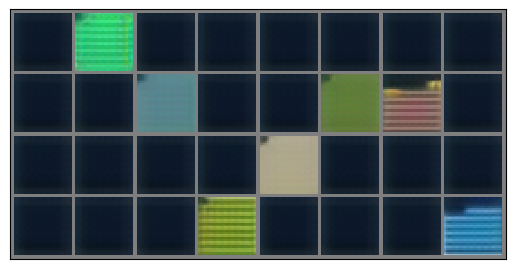

In [35]:
show(make_grid(x_recon.cpu().data) + 0.5, )

# Linear Classification

In [41]:
class ClfHead(nn.Module):

    def __init__(self, num_classes=10):
        super().__init__()
        self.module = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x):
        return self.module(x)

In [42]:
device = torch.device("mps")
model.to(device)
image_gpt_train_dataset = ImageGPTDataset(model, training_data, 512, with_latents=True)
image_gpt_test_dataset = ImageGPTDataset(model, validation_data, 512, with_latents=True)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [43]:
len(image_gpt_train_dataset), len(training_data)

(50000, 50000)

In [44]:
import torch.nn.functional as F
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
from plotly.subplots import make_subplots

device = torch.device('mps')

data_loader = DataLoader(
    image_gpt_train_dataset,
    batch_size=128,
)
test_data_loader = DataLoader(
    image_gpt_test_dataset,
    batch_size=256,
    shuffle=False,
)
linear_clf = ClfHead(num_classes=10).to(device)
model.to(device)

optimizer = torch.optim.Adam(linear_clf.parameters(), lr=0.0001)

train_losses = []
train_acc = []
train_x = []

test_losses = []
test_acc = []
test_x = []

for i in range(len(train_x), 1000):
    linear_clf.train()

    epoch_losses = []
    epoch_acc = []
    for batch in tqdm(data_loader):
        optimizer.zero_grad()

        batch['latents'] = batch['latents'].to(device)
        batch['labels'] = batch['labels'].to(device)

        output = linear_clf(batch['latents'])
        loss = F.cross_entropy(output, batch['labels'])
        acc = (output.argmax(-1) == batch['labels']).float().mean()

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.cpu().item())
        epoch_acc.append(acc.cpu().item())
    
    train_losses.append(np.mean(epoch_losses))
    train_acc.append(np.mean(epoch_acc))
    train_x.append(i)
    
    if i % 2 ==0:
        linear_clf.eval()
        epoch_losses = []
        epoch_acc = []

        with torch.no_grad():
            for batch in tqdm(test_data_loader):
                batch['latents'] = batch['latents'].to(device)
                batch['labels'] = batch['labels'].to(device)

                output = linear_clf(batch['latents'])
                loss = F.cross_entropy(output, batch['labels'])
                acc = (output.argmax(-1) == batch['labels']).float().mean()
                
                epoch_losses.append(loss.cpu().item())
                epoch_acc.append(acc.cpu().item())

        test_losses.append(np.mean(epoch_losses))
        test_acc.append(np.mean(epoch_acc))
        test_x.append(i)
        
    
    
    clear_output(wait=True)
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=test_x, y=test_losses, mode='lines', name='test loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=train_x, y=train_losses, mode='lines', name='train loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=test_x, y=test_acc, mode='lines', name='test acc'), row=2, col=1)
    fig.add_trace(go.Scatter(x=train_x, y=train_acc, mode='lines', name='train acc'), row=2, col=1)
    fig.show()

  0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: 

# ImageGPT classification

In [169]:
from transformers import ImageGPTConfig, ImageGPTForImageClassification


configuration = ImageGPTConfig(**{
    "activation_function": "quick_gelu",
    "attn_pdrop": 0.1,
    "embd_pdrop": 0.1,
    "initializer_range": 0.02,
    "layer_norm_epsilon": 1e-05,
    "model_type": "imagegpt",
    "n_embd": 64,
    "n_head": 4,
    "n_layer": 2,
    "n_positions": 8*8+2,
    "reorder_and_upcast_attn": False,
    "resid_pdrop": 0.1,
    "scale_attn_by_inverse_layer_idx": False,
    "scale_attn_weights": True,
    "tie_word_embeddings": False,
    "use_cache": False,
    "vocab_size": num_embeddings + 2,
    "num_labels": 10
})
image_gpt_clf = ImageGPTForImageClassification(configuration)
# image_gpt_clf.transformer.wte.weight.data[1:-1] = model._vq_vae._embedding.weight.data
# image_gpt_clf.transformer.wte.weight.requires_grad = False

In [170]:
import torch.nn.functional as F
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
from plotly.subplots import make_subplots

device = torch.device('mps')

data_loader = DataLoader(
    image_gpt_train_dataset,
    batch_size=512,
)
test_data_loader = DataLoader(
    image_gpt_test_dataset,
    batch_size=512,
    shuffle=False,
)


optimizer = torch.optim.Adam(image_gpt_clf.parameters(), lr=0.0001)
image_gpt_clf.to(device)

train_losses = []
train_acc = []
train_x = []

test_losses = []
test_acc = []
test_x = []

for i in range(len(train_x), 600):
    image_gpt_clf.train()

    epoch_losses = []
    epoch_acc = []
    for batch in tqdm(data_loader):
        optimizer.zero_grad()

        batch['input_ids'] = batch['input_ids'].to(device)
        batch['labels'] = batch['labels'].to(device)

        output = image_gpt_clf(**batch)
        loss = F.cross_entropy(output.logits, batch['labels'])
        acc = (output.logits.argmax(-1) == batch['labels']).float().mean()

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.cpu().item())
        epoch_acc.append(acc.cpu().item())
    
    train_losses.append(np.mean(epoch_losses))
    train_acc.append(np.mean(epoch_acc))
    train_x.append(i)
    
    if i % 2 ==0:
        image_gpt_clf.eval()
        epoch_losses = []
        epoch_acc = []

        with torch.no_grad():
            for batch in tqdm(test_data_loader):
                batch['input_ids'] = batch['input_ids'].to(device)
                batch['labels'] = batch['labels'].to(device)

                output = image_gpt_clf(**batch)
                loss = F.cross_entropy(output.logits, batch['labels'])
                acc = (output.logits.argmax(-1) == batch['labels']).float().mean()

                epoch_losses.append(loss.cpu().item())
                epoch_acc.append(acc.cpu().item())

        test_losses.append(np.mean(epoch_losses))
        test_acc.append(np.mean(epoch_acc))
        test_x.append(i)
        
    
    
    clear_output(wait=True)
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=test_x, y=test_losses, mode='lines', name='test loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=train_x, y=train_losses, mode='lines', name='train loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=test_x, y=test_acc, mode='lines', name='test acc'), row=2, col=1)
    fig.add_trace(go.Scatter(x=train_x, y=train_acc, mode='lines', name='train acc'), row=2, col=1)
    fig.show()

  0%|          | 0/98 [00:00<?, ?it/s]

KeyboardInterrupt: 